In [5]:
import xarray
import xesmf as xe
import numpy as np
from paths import heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax_paths
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin_paths
from paths import population_2020_aggregated
import dask

variable = "HWF"
exp_num = "3136"
min_max = "tn"
all_member_paths = [path for path in tmin_paths()[0] if exp_num in path]
xghg_member_paths = [path for path in tmin_paths()[1] if exp_num in path]
xaer_member_paths = [path for path in tmin_paths()[2] if exp_num in path]
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    all_data = xarray.open_mfdataset(all_member_paths, concat_dim="member", combine="nested")[f"{variable}_{min_max}90"].dt.days
    xaer_data = xarray.open_mfdataset(xaer_member_paths, concat_dim="member", combine="nested")[f"{variable}_{min_max}90"].dt.days
    xghg_data = xarray.open_mfdataset(xghg_member_paths, concat_dim="member", combine="nested")[f"{variable}_{min_max}90"].dt.days

    # Shift data
    all_data = all_data.assign_coords(lon=(((all_data.lon + 180) % 360) - 180)).sortby('lon')
    xaer_data = xaer_data.assign_coords(lon=(((xaer_data.lon + 180) % 360) - 180)).sortby('lon')
    xghg_data = xghg_data.assign_coords(lon=(((xghg_data.lon + 180) % 360) - 180)).sortby('lon')

    lat_delta = (all_data.lat.values[1] - all_data.lat.values[0]) / 2
    lon_delta = (all_data.lon.values[1] - all_data.lon.values[0]) / 2
    lats = np.append(all_data.lat.values - lat_delta, all_data.lat.values[-1::])
    lons = np.append(all_data.lon.values - lon_delta, all_data.lon.values[-1::])
    pop_data = xarray.open_rasterio(population_2020_aggregated()).rename({"x":"lon", "y":"lat"})
    resampled_pop = pop_data.where(pop_data > 0).astype(np.float64).groupby_bins("lat", lats).sum().groupby_bins("lon", lons).sum()
    resampled_pop = resampled_pop.rename({"lat_bins":"lat", "lon_bins":"lon"}).sel(band=1)

In [6]:
import timeit

start = timeit.default_timer()

all_export = all_data.groupby("time").apply(lambda time_slice: np.multiply(resampled_pop.values, time_slice.values))

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  256.61523761600256


In [70]:
all_data = xarray.open_mfdataset(all_member_paths, concat_dim="member", combine="nested")[f"{variable}_{min_max}90"].dt.days
start = timeit.default_timer()

all_export2 = all_data.groupby("time").apply(lambda time_slice: time_slice*resampled_pop.values)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  0.5786674730479717


In [63]:
all_export = all_data.groupby("time").apply(lambda ts: ts*resampled_pop.values)

/projects/dgs/rh5_local/anaconda/climate/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


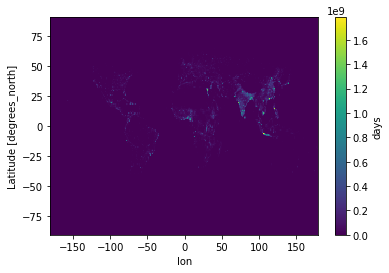

In [66]:
all_export.mean(dim="member").mean(dim="time").plot()

In [20]:
from paths import population_2020_aggregated
from paths import heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax_paths
import xarray
import numpy as np
import xesmf as xe

variable="HWF"
min_max="tx"


all_member_paths = [path for path in tmax_paths()[0] if exp_num in path]
all_data = xarray.open_mfdataset(all_member_paths, concat_dim="member", combine="nested")[f"{variable}_{min_max}90"].dt.days.mean(dim="member")
all_data = all_data.assign_coords(lon=(((all_data.lon + 180) % 360) - 180)).sortby('lon')

lat_delta = (all_data.lat.values[1] - all_data.lat.values[0]) / 2
lon_delta = (all_data.lon.values[1] - all_data.lon.values[0]) / 2
lats = np.append(all_data.lat.values - lat_delta, all_data.lat.values[-1::])
lons = np.append(all_data.lon.values - lon_delta, all_data.lon.values[-1::])

pop_data = xarray.open_rasterio(population_2020_aggregated()).rename({"x":"lon", "y":"lat"})
resampled_pop = pop_data.where(pop_data > 0).astype(np.float64).groupby_bins("lat", lats).sum().groupby_bins("lon", lons).sum()
resampled_pop = resampled_pop.rename({"lat_bins":"lat", "lon_bins":"lon"}).sel(band=1)

In [33]:
time_slice = all_data.sel(time=1920)

In [22]:
time_slice.shape

(192, 288)

In [24]:
resampled_pop.shape

(192, 288)

In [27]:
weighted = np.multiply(time_slice.values, resampled_pop.values)

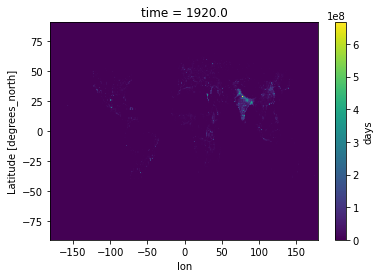

In [37]:
time_slice.values = weighted
time_slice.plot()

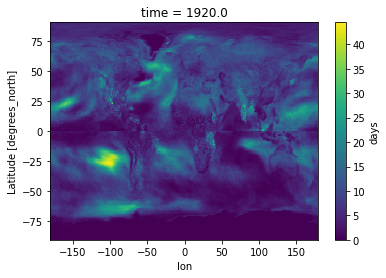

In [36]:
time_slice.plot()

In [ ]:
# import pop_weighted as pw
# import xarray
# import numpy as np
# from regionmask.defined_regions import ar6
# import matplotlib.pyplot as plt
# from matplotlib import colors
# from matplotlib import rc
# from matplotlib.patches import Patch
# import paths
# # from matplotlib.backends.backend_pdf import PdfPages
# time_begin=2020
# time_end=2040
# var = "HWF"
# exp_num = "3136"

# #weighted_all, weighted_xghg, weighted_xaer, all_data, xghg_data, xaer_data, error = pw.weighted(variable, exp_num, min_max)
# weighted_all = xarray.open_dataset("weighted_all.nc")
# weighted_xghg = xarray.open_dataset("weighted_xghg.nc")
# weighted_xaer = xarray.open_dataset("weighted_xaer.nc")
# all_data = xarray.open_dataset("shifted_all_data.nc")
# xaer_data = xarray.open_dataset("shifted_xaer_data.nc")
# xghg_data = xarray.open_dataset("shifted_xghg_data.nc")

# time_range=[str(date) for date in list(range(time_begin, time_end + 1))]
# spatial_avg_time_slice = lambda ds : ds.sel(time=time_range)

# all_min_tavg, xghg_min_tavg, xaer_min_tavg, all_min, xghg_min, xaer_min, error_min = pw.weighted(variable, exp_num, "tn")

# all_max_tavg, xghg_max_tavg, xaer_max_tavg, all_max, xghg_max, xaer_max, error_max = pw.weighted(variable, exp_num, "tx")

# f, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 35), facecolor='w')
# f.suptitle(f"{var} Exp. {exp_num} AR6 Regional Averages from {time_begin} to {time_end}", fontsize=50)
# font = {'weight': 'bold',
#         'size': 16}
# rc('font', **font)

# all_max_regions = [(ar6.land.regions[index], value) for index, value in enumerate(all_max_tavg.groupby(ar6.land.mask(all_max_tavg)).mean().values)]
# xghg_max_values = [value for value in xghg_max_tavg.groupby(ar6.land.mask(xghg_max_tavg)).mean().values]
# xaer_max_values = [value for value in xaer_max_tavg.groupby(ar6.land.mask(xaer_max_tavg)).mean().values]

# bar_height = 5
# y_labels = []
# legend_elements = [Patch(facecolor='blue', label='ALL'),
#                   Patch(facecolor='green', label='XGHG'),
#                   Patch(facecolor='red', label='XAER')]

# for region, all_value in all_max_regions:
#     num = region.number
#     y_labels.append(region.name)
#     xghg_value = xghg_max_values[num]
#     xaer_value = xaer_max_values[num]
#     plot_all = lambda : ax1.barh(num*bar_height, all_value, height=bar_height-1, align='center', color="blue")
#     plot_xghg = lambda : ax1.barh(num*bar_height, xghg_value, height=bar_height-1, align='center', color="green")
#     plot_xaer = lambda : ax1.barh(num*bar_height, xaer_value, height=bar_height-1, align='center', color="red")
#     plots = [(all_value, plot_all), (xghg_value, plot_xghg), (xaer_value, plot_xaer)]
#     plots.sort()
#     for index, (val, func) in enumerate(plots[::-1]):
#         func()
#         if index == 1:
#             ax1.text(val, num*bar_height-1, np.round(val, 0), color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0})
#         else:
#             ax1.text(val, num*bar_height-1, np.round(val, 0), color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0})
# ax1.set_title("Using Max. Temperature", fontsize=30)
# ax1.set_yticks(np.linspace(0, 225, len(y_labels)))
# ax1.set_yticklabels(y_labels)
# ax1.grid()
# ax1.legend(handles=legend_elements, loc='upper right')

# all_min_regions = [(ar6.land.regions[index], value) for index, value in enumerate(all_min_tavg.groupby(ar6.land.mask(all_min_tavg)).mean().values)]
# xghg_min_values = [value for value in xghg_min_tavg.groupby(ar6.land.mask(xghg_min_tavg)).mean().values]
# xaer_min_values = [value for value in xaer_min_tavg.groupby(ar6.land.mask(xaer_min_tavg)).mean().values]

# for region, all_value in all_min_regions:
#     num = region.number
#     xghg_value = xghg_min_values[num]
#     xaer_value = xaer_min_values[num]
#     plot_all = lambda : ax2.barh(num*bar_height, all_value, height=bar_height-1, align='center', color="blue")
#     plot_xghg = lambda : ax2.barh(num*bar_height, xghg_value, height=bar_height-1, align='center', color="green")
#     plot_xaer = lambda : ax2.barh(num*bar_height, xaer_value, height=bar_height-1, align='center', color="red")
#     plots = [(all_value, plot_all), (xghg_value, plot_xghg), (xaer_value, plot_xaer)]
#     try:
#         plots.sort()
#     except TypeError:
#         pass
#     for index, (val, func) in enumerate(plots[::-1]):
#         func()
#         if index == 1:
#             ax2.text(val, num*bar_height-1, np.round(val, 0), color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0})
#         else:
#             ax2.text(val, num*bar_height-1, np.round(val, 0), color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0})
# ax2.set_title("Using Min. Temperature", fontsize=30)
# ax2.set_yticks(np.linspace(0, 225, len(y_labels)))
# ax2.set_yticklabels(y_labels)
# ax2.grid()
# ax2.legend(handles=legend_elements, loc='upper right')
# f.savefig("out.png")


In [ ]:
# import cProfile, pstats, io
# import pop_weighted as pw
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()

# var = "HWF"
# exp_num = "3136"
# weighted_all, weighted_xghg, weighted_xaer, all_data, xghg_data, xaer_data, error = pw.weighted_CESM(var, exp_num, "tx")

# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

In [ ]:
# ranges = [(1920, 1960), (1960, 2000), (2000, 2040), (2040, 2080)]
# for beg, end in ranges:
#     time_begin=beg
#     time_end=end
#     time_range=[str(date) for date in list(range(time_begin, time_end + 1))]
#     sliced_w_all = weighted_all.sel(time=time_range)
#     all_max_regions = [(ar6.land.regions[index], value) for index, value in enumerate(sliced_w_all.groupby(ar6.land.mask(sliced_w_all)).mean().days)]

#     f, ax1 = plt.subplots(1, 1, figsize=(30, 10), facecolor='w')
#     f.suptitle(f"Pop. Weighted ALL {variable} Exp. {exp_num} 95th Percentile AR6 Regional Averages from {time_begin} to {time_end}", fontsize=30)
#     font = {'weight': 'bold',
#             'size': 16}
#     rc('font', **font)

#     max_percentile = np.percentile([value.mean() for region, value in all_max_regions], 95)
#     i = 0
#     for region, values in all_max_regions:
#         #if np.max(values) > max_percentile:
#             #values.plot(ax=ax1, label=region.name, linewidth=3)
#         ax1.barh(5*i, values.mean(), label=region.name)
#         i += 1
#     ax1.legend()
#     #f.savefig(f"out_{time_begin}_{time_end}.png")

In [ ]:
# f, ax1 = plt.subplots(1, 1, figsize=(25, 10), facecolor='w')
# f.suptitle(f"ALL Max. {variable} Exp. {exp_num} Global Spatial Averages", fontsize=30)
# font = {'weight': 'bold',
#         'size': 16}
# rc('font', **font)
# all_data.mean(dim="lat").mean(dim="lon").plot(ax=ax1, label="ALL", linewidth=3)
# (all_data - xghg_data).mean(dim="lat").mean(dim="lon").plot(ax=ax1, label="GHG", linewidth=3)
# (all_data - xaer_data).mean(dim="lat").mean(dim="lon").plot(ax=ax1, label="AER", linewidth=3)
# ax1.legend()
# ax1.grid()

# # why is ALL greater than GHG? Shouldn't it be less than GHG due to the effect of AER? pain

In [ ]:
# f, ax1 = plt.subplots(1, 1, figsize=(25, 10), facecolor='w')
# f.suptitle(f"2020 Pop. Weighted ALL Max. {variable} Exp. {exp_num} Global Spatial Averages", fontsize=30)
# font = {'weight': 'bold',
#         'size': 16}
# rc('font', **font)
# weighted_all.mean(dim="lat").mean(dim="lon").days.plot(ax=ax1, label="ALL", linewidth=3)
# (weighted_all - weighted_xghg).mean(dim="lat").mean(dim="lon").days.plot(ax=ax1, label="AER", linewidth=3)
# (weighted_all - weighted_xaer).mean(dim="lat").mean(dim="lon").days.plot(ax=ax1, label="GHG", linewidth=3)
# ax1.legend()
# ax1.grid()
# f.savefig("out.png")

In [ ]:
#ar6.land.mask(all_max_tavg.days)

In [ ]:
# for x in all_max_tavg.groupby(ar6.land.mask(all_max_tavg)).mean().days:
#     print(x)
#all_max_tavg.groupby(ar6.land.mask(all_max_tavg)).mean().days

In [ ]:
# time_begin=2020
# time_end=2060
# time_range=[str(date) for date in list(range(time_begin, time_end + 1))]
# spatial_avg_time_slice = lambda ds : ds.sel(time=time_range)

# all_max_tavg = spatial_avg_time_slice(weighted_all).mean(dim="time")
# xghg_max_tavg = spatial_avg_time_slice(weighted_xghg).mean(dim="time")
# xaer_max_tavg = spatial_avg_time_slice(weighted_xaer).mean(dim="time")

# f, ax1 = plt.subplots(1, 1, figsize=(25, 35), facecolor='w')
# f.suptitle(f"{variable} Exp. {exp_num} AR6 Regional Averages from {time_begin} to {time_end}", fontsize=50)
# font = {'weight': 'bold',
#         'size': 16}
# rc('font', **font)

# all_max_regions = [(ar6.land.regions[index], value) for index, value in enumerate(all_max_tavg.groupby(ar6.land.mask(all_max_tavg)).mean().days)]
# xghg_max_values = [value for value in xghg_max_tavg.groupby(ar6.land.mask(xghg_max_tavg)).mean().days]
# xaer_max_values = [value for value in xaer_max_tavg.groupby(ar6.land.mask(xaer_max_tavg)).mean().days]

# bar_height = 5
# y_labels = []
# # legend_elements = [Patch(facecolor='blue', label='ALL'),
# #                   Patch(facecolor='green', label='XGHG'),
# #                   Patch(facecolor='red', label='XAER')]

# for region, all_value in all_max_regions:
#     all_value = all_value.values
#     num = region.number
#     y_labels.append(region.name)
#     xghg_value = xghg_max_values[num].values
#     xaer_value = xaer_max_values[num].values
#     ax1.barh(num*bar_height, all_value, height=bar_height-1, align='center', color="blue")
#     ax1.text(all_value, num*bar_height+1, np.round(all_value, 0), color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0})
    
#     ax1.barh(num*bar_height, xghg_value, height=bar_height-1, align='center', color="green")
#     ax1.text(xghg_value, num*bar_height-1, np.round(xghg_value, 0), color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0})
    
#     ax1.barh(num*bar_height, xaer_value, height=bar_height-1, align='center', color="red")
#     ax1.text(xaer_value, num*bar_height-3, np.round(xaer_value, 0), color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0})
    
# #     plots = [(all_value, plot_all), (xghg_value, plot_xghg), (xaer_value, plot_xaer)]
# #     #plots.sort()
# #     for index, (val, func) in enumerate(plots[::-1]):
# #         func()
# #         if index == 1:
# #             ax1.text(val, num*bar_height-1, np.round(val, 0), color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0})
# #         else:
# #             ax1.text(val, num*bar_height-1, np.round(val, 0), color='black', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 0})
# ax1.set_title("Using Max. Temperature", fontsize=30)
# ax1.set_yticks(np.linspace(0, 225, len(y_labels)))
# ax1.set_yticklabels(y_labels)
# ax1.grid()
# #ax1.legend(handles=legend_elements, loc='upper right')

In [ ]:
all_max_regions[0][1].values